# Stock V: Sharp Mean Reversion Strategy

Stock V exhibits mean-reverting behavior due to retail trading activity creating inefficiencies after momentum changes. This notebook implements a z-score based mean reversion strategy that trades against extreme momentum.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)

## Configuration

In [2]:
# Data
CSV_PATH = "simulated_prices.csv"
TICKER = "V"

# Strategy parameters
LOOKBACK = 22        # Days for momentum calculation
VOL_WIN = 22         # Window for volatility estimate
Z_ENTRY = 2.0        # Z-score threshold to enter position
Z_EXIT = 1.0         # Z-score threshold to exit position
COST_BPS = 0.0       # Transaction costs in basis points
ANNUALIZATION = 252  # Trading days per year

## Helper Functions

In [3]:
def ann_sharpe(r: pd.Series, ann=252) -> float:
    """Annualized Sharpe ratio."""
    r = r.dropna()
    if len(r) < 2 or r.std() == 0:
        return np.nan
    return np.sqrt(ann) * r.mean() / r.std()

def ann_sortino(r: pd.Series, ann=252) -> float:
    """Annualized Sortino ratio."""
    r = r.dropna()
    down = r[r < 0]
    if len(down) < 2 or down.std() == 0:
        return np.nan
    return np.sqrt(ann) * r.mean() / down.std()

def max_drawdown(eq: pd.Series) -> float:
    """Maximum drawdown from peak."""
    return (eq / eq.cummax() - 1.0).min()

def apply_costs(strat_ret: pd.Series, pos: pd.Series, cost_bps: float) -> pd.Series:
    """Apply transaction costs based on turnover."""
    if cost_bps <= 0:
        return strat_ret
    turnover = pos.diff().abs().fillna(0.0)
    return strat_ret - (cost_bps / 1e4) * turnover

## Load Data

In [4]:
raw = pd.read_csv(CSV_PATH)
raw.columns = [str(c).strip() for c in raw.columns]

# Drop date string column, use numeric index
df = raw.drop(columns=[raw.columns[0]]).apply(pd.to_numeric, errors="coerce")
df.index = pd.date_range("2000-01-03", periods=len(df), freq="B")

px = df[TICKER].dropna()
print(f"Stock {TICKER}: {len(px)} observations")
print(f"Date range: {px.index[0].date()} to {px.index[-1].date()}")

Stock V: 2521 observations
Date range: 2000-01-03 to 2009-08-31


## Price Visualization

Observe the mean-reverting behavior - sharp moves tend to reverse.

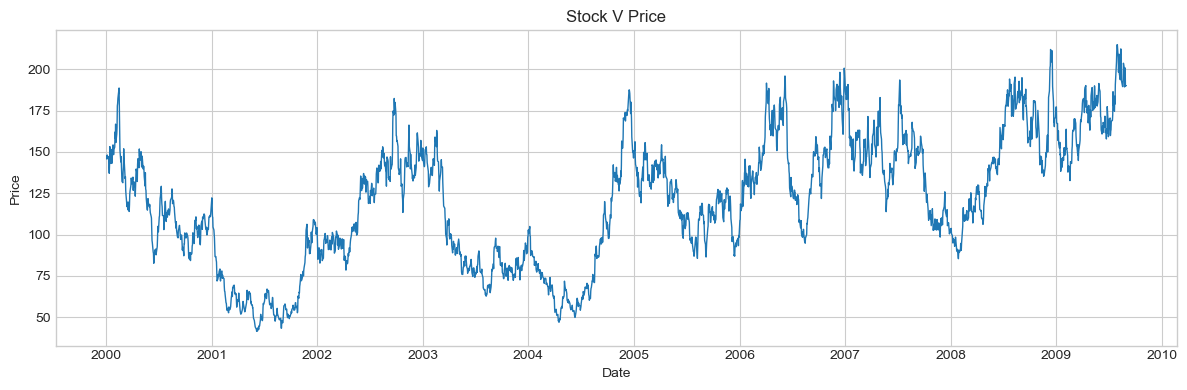

In [5]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(px.index, px.values, linewidth=1)
ax.set_title(f'Stock {TICKER} Price', fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.tight_layout()
plt.show()

## Signal Generation

**Mean Reversion Logic:**
- Calculate momentum as the LOOKBACK-day log return
- Normalize by rolling volatility to get a z-score
- **Short** when z > Z_ENTRY (overbought, expect reversion down)
- **Long** when z < -Z_ENTRY (oversold, expect reversion up)
- Use hysteresis (Z_EXIT) to reduce whipsaw

In [6]:
# Calculate returns and momentum
logp = np.log(px)
ret = logp.diff().dropna()
mom = logp.diff(LOOKBACK)

# Rolling volatility and z-score
vol = ret.rolling(VOL_WIN).std()
z = mom / (vol * np.sqrt(LOOKBACK))

# Hysteresis-based position signal
sig = pd.Series(0.0, index=logp.index)
pos = 0.0

for t in range(len(sig)):
    zi = z.iloc[t]
    if np.isnan(zi):
        sig.iloc[t] = pos
        continue
    
    if pos == 0.0:  # Entry
        if zi > Z_ENTRY:
            pos = 1.0
        elif zi < -Z_ENTRY:
            pos = -1.0
    elif pos == 1.0:  # Exit long
        if zi < Z_EXIT:
            pos = 0.0
    elif pos == -1.0:  # Exit short
        if zi > -Z_EXIT:
            pos = 0.0
    
    sig.iloc[t] = pos

# Flip for mean reversion: high momentum -> short, low momentum -> long
sig = -sig
sig = sig.reindex(ret.index)

# Apply position next day (no lookahead)
pos_trade = sig.shift(1).fillna(0.0)

print(f"Position distribution:")
print(pos_trade.value_counts().sort_index())

Position distribution:
-1.0      92
 0.0    2278
 1.0     150
Name: count, dtype: int64


## Backtest

In [7]:
# Strategy returns
strat_ret = pos_trade * ret
strat_ret = apply_costs(strat_ret, pos_trade, COST_BPS)
equity = (1 + strat_ret.fillna(0.0)).cumprod()

# Metrics
total_return = equity.iloc[-1] - 1.0
years = (equity.index[-1] - equity.index[0]).days / 365.25
cagr = equity.iloc[-1] ** (1 / years) - 1 if years > 0 else np.nan
sharpe = ann_sharpe(strat_ret, ANNUALIZATION)
sortino = ann_sortino(strat_ret, ANNUALIZATION)
mdd = max_drawdown(equity)

print(f"\n{'='*50}")
print(f"MEAN REVERSION BACKTEST: Stock {TICKER}")
print(f"{'='*50}")
print(f"Parameters: LOOKBACK={LOOKBACK}, Z_ENTRY={Z_ENTRY}, Z_EXIT={Z_EXIT}")
print(f"{'='*50}")
print(f"Total Return:   {total_return:>10.2%}")
print(f"CAGR:           {cagr:>10.2%}")
print(f"Sharpe (ann):   {sharpe:>10.2f}")
print(f"Sortino (ann):  {sortino:>10.2f}")
print(f"Max Drawdown:   {mdd:>10.2%}")
print(f"{'='*50}")


MEAN REVERSION BACKTEST: Stock V
Parameters: LOOKBACK=22, Z_ENTRY=2.0, Z_EXIT=1.0
Total Return:      242.25%
CAGR:               13.59%
Sharpe (ann):         0.72
Sortino (ann):        0.43
Max Drawdown:      -34.77%


## Results Visualization

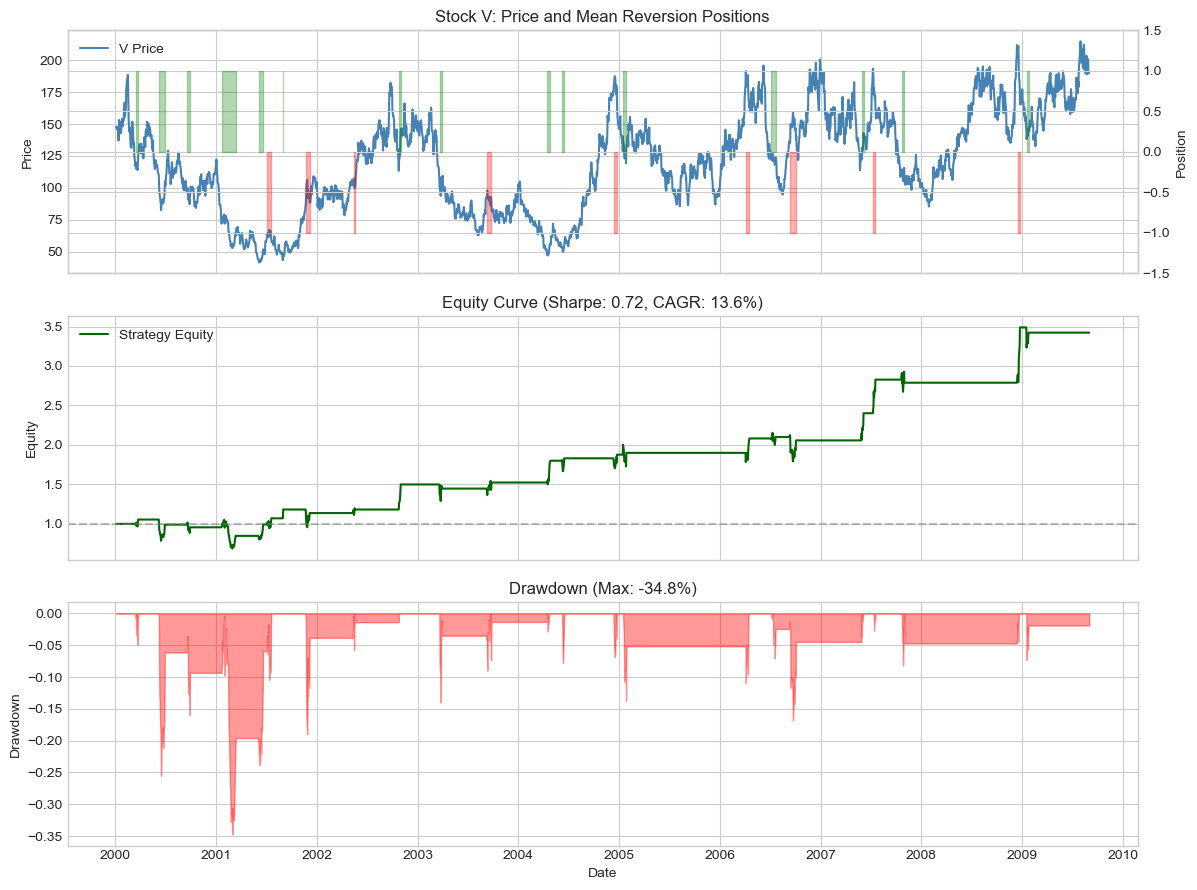

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# Price with position overlay
ax1 = axes[0]
ax1.plot(px.loc[ret.index], label=f'{TICKER} Price', color='steelblue')
ax1.set_ylabel('Price')
ax1.set_title(f'Stock {TICKER}: Price and Mean Reversion Positions')
ax1.legend(loc='upper left')

ax1b = ax1.twinx()
ax1b.fill_between(pos_trade.index, pos_trade.values, alpha=0.3, 
                  color='green', where=pos_trade > 0, label='Long')
ax1b.fill_between(pos_trade.index, pos_trade.values, alpha=0.3, 
                  color='red', where=pos_trade < 0, label='Short')
ax1b.set_ylabel('Position')
ax1b.set_ylim(-1.5, 1.5)

# Equity curve
ax2 = axes[1]
ax2.plot(equity, label='Strategy Equity', color='darkgreen', linewidth=1.5)
ax2.axhline(1, color='gray', linestyle='--', alpha=0.5)
ax2.set_ylabel('Equity')
ax2.set_title(f'Equity Curve (Sharpe: {sharpe:.2f}, CAGR: {cagr:.1%})')
ax2.legend()

# Drawdown
ax3 = axes[2]
dd = equity / equity.cummax() - 1.0
ax3.fill_between(dd.index, dd.values, color='red', alpha=0.4)
ax3.set_ylabel('Drawdown')
ax3.set_xlabel('Date')
ax3.set_title(f'Drawdown (Max: {mdd:.1%})')

plt.tight_layout()
plt.show()

## Z-Score Analysis

Visualize the momentum z-score and entry/exit thresholds.

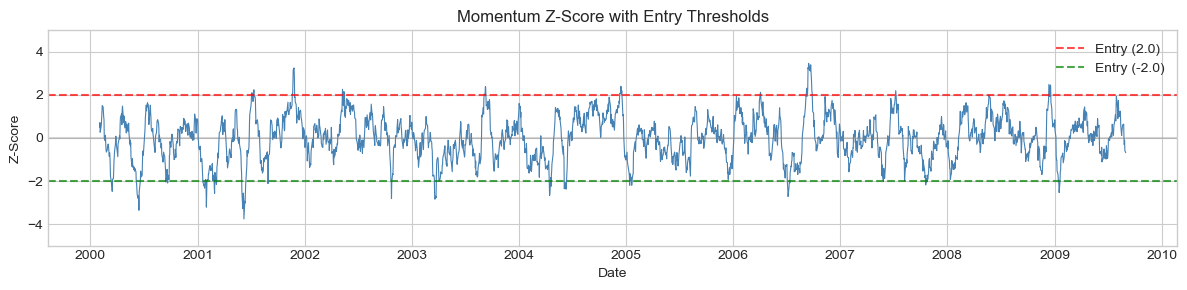

In [9]:
fig, ax = plt.subplots(figsize=(12, 3))
z_plot = z.dropna()
ax.plot(z_plot.index, z_plot.values, linewidth=0.8, color='steelblue')
ax.axhline(Z_ENTRY, color='red', linestyle='--', alpha=0.7, label=f'Entry ({Z_ENTRY})')
ax.axhline(-Z_ENTRY, color='green', linestyle='--', alpha=0.7, label=f'Entry (-{Z_ENTRY})')
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax.set_ylabel('Z-Score')
ax.set_xlabel('Date')
ax.set_title('Momentum Z-Score with Entry Thresholds')
ax.legend()
ax.set_ylim(-5, 5)
plt.tight_layout()
plt.show()